### Scraping

In [2]:
import selenium
from selenium import webdriver
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
import re
import csv

def make_unicode(str_in):
    if type(str_in) != unicode:
        str_in =  str_in.encode('utf-8', 'ignore')
        return str_in
    else:
        return str_in
    
#Initialize log to check response per issue
with open("log.txt","w+") as logfile:
    logfile.write("volume, issue, url, response\n")

#Access Nature archive page where we can get the articles
response = requests.get('http://www.nature.com/nature/archive/index.html')
print ("Response from Nature archive/index.html " + str(response))
bs_doc = BeautifulSoup(response.text, "html5lib")

#Extract url directories append to http://www.nature.com in one list
master_list = ['http://www.nature.com' + a.find('a')['href'].strip() for a in bs_doc.find_all('li') if a.find('a') is not None]

list_of_titles = []
list_to_df = []
doc_counter  = 0
#Main loop over issues/volumes
for issue_url in master_list[20:]:
    #Shitty supplemental materials
    if 'supp' in issue_url:
        continue
    
    #Extract some meta info to be written to log
    try:
        issue = re.search(r"n(\d+)", issue_url).group(1)
        volume = re.search(r"v(\d+)", issue_url).group(1)
    except:
        None
    
    response = requests.get(issue_url)
    
    #Write issue/volume and url response to log file
    with open('log.txt', 'a') as logfile:
        log_writer = csv.writer(logfile, delimiter=',')
        log_writer.writerow([volume, issue, issue_url, re.search(r"(\d{3})", str(response)).group(1)])
    
    
    issue_doc = BeautifulSoup(response.text, "html5lib")
    research_table = issue_doc.find("div", {"id":"research", "class" : "section"})
    
    #Loop over artciles within issue/volume
    with open('out.txt', 'a') as outfile:
        out_writer = csv.writer(outfile, delimiter=',')
        
        #REMINDER: format of out.txt
        #volume, issue, date, title, authors, summary, text
        
        #loop over articles listed in research section
        #first link listed as '#top' which we don't care about
        if table is None:
            continue
            
        for article_url in research_table.find_all('a')[1:]:
            if article_url['href'] == "#top":
                continue
                
            try:
                response = requests.get(article_url['href'])
                article_doc = BeautifulSoup(response.text, "html5lib").find("article")
            except:
                response = requests.get('http://www.nature.com' + article_url['href'])
                article_doc = BeautifulSoup(response.text, "html5lib").find("article")
            
            if article_doc is None:
                continue
                
                
            title = article_doc.find("h1").text
            if title in list_of_titles:
                continue
                
            list_of_titles.append(title)

            try:
                list_to_df.append([volume, 
                                      issue, 
                                      title, 
                                      article_doc.find("a").text.strip().encode('utf-8', 'ignore').decode('utf-8'),
                                      article_doc.find("h1").find_next("div").text.encode('utf-8', 'ignore').decode('utf-8'),
                                      "\n\n".join([div.find('p').text.strip() for div in article_doc.find_all("div")[1:] if div.find('p') is not None]).encode('utf-8', 'ignore').decode('utf-8')])
                doc_counter += 1
            except:
                print(article_doc.find("h1").text)
                
    #wait randomly
    wait_time = np.random.uniform(0,1, size=1)
    time.sleep(wait_time)

#//*[@id="content"]/div/div/article/div[1]/header/div/h1
print('Done!', doc_counter)

Response from Nature archive/index.html <Response [200]>


NameError: name 'table' is not defined

In [ ]:
print('Done!', doc_counter)

### Quick LDA visualization with sklearn

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans

import pandas as pd

#df = pd.read_csv("out.txt", delimiter = ',', encoding='latin1')
#df['text'].apply(lambda x: bytearray(x, 'utf-8'))
df = pd.DataFrame(list_to_df)
df.columns = ['volume', 'index', 'title', 'authors', 'summary', 'text']
df.to_csv('nature.txt')

df['text'] = df['text'].apply(lambda x: re.sub(r"199", "", x))
vectorizer = CountVectorizer(stop_words="english", ngram_range=(2,2))

#Fit and transform the count vectorizer
X_counts = vectorizer.fit_transform(df['text'])

lda = LatentDirichletAllocation(n_topics=10, learning_method='batch')
lda.fit(X_counts)

def print_top_words(model, feature_names, n_top_words):
    print('\n--------------------------------\n')
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % (topic_idx+1))
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print_top_words(lda, vectorizer.get_feature_names(),n_top_words = 15)


--------------------------------

Topic #1:
et al, file contains, news views, nature letter, contains supplementary, long term, extended data, letter nature, nature news, 10 1038, authors contributed, al report, acknowledges support, research council, doi 10
Topic #2:
file contains, contains supplementary, et al, news views, nature letter, supplementary tables, letter nature, nature news, work supported, electron microscopy, authors contributed, editing levels, views nature, gene expression, science foundation
Topic #3:
file contains, contains supplementary, et al, extended data, stem cells, news views, data fig, work supported, nature news, supplementary table, research council, supplementary tables, stem cell, breast cancer, authors contributed
Topic #4:
file contains, et al, nature letter, contains supplementary, letter nature, news views, nature news, cell cycle, pd l1, authors contributed, work supported, colleagues report, stem cells, wrote manuscript, views nature
Topic #5:
fil

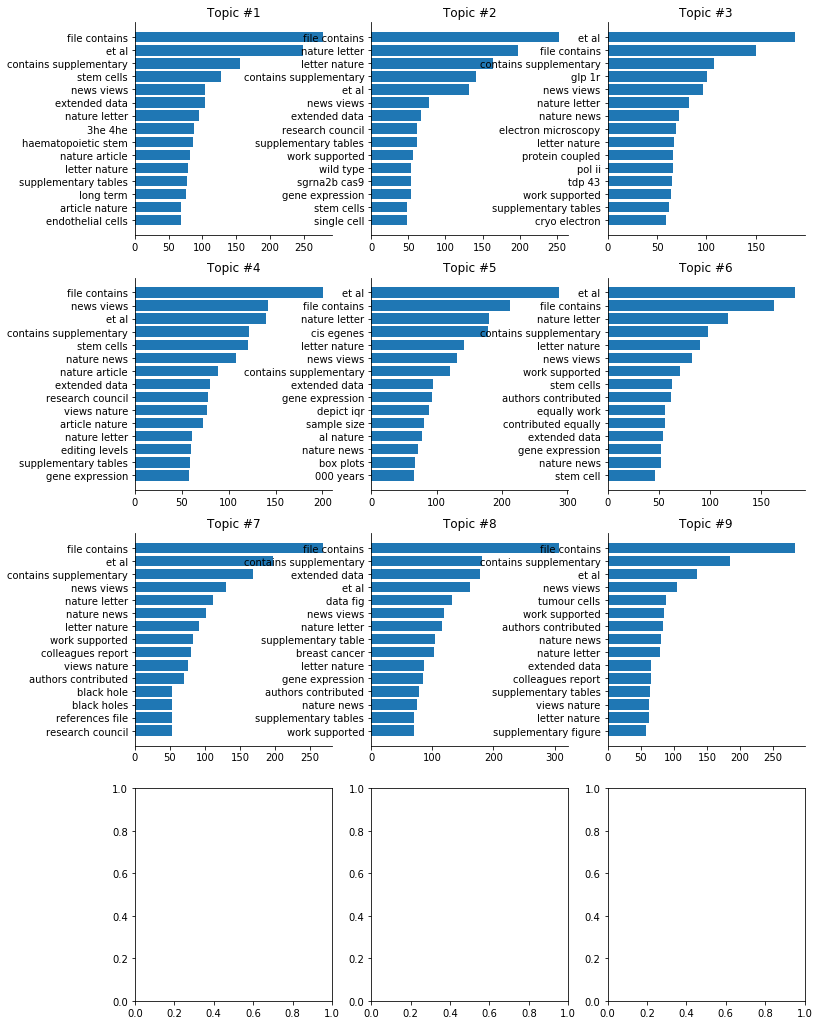

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_features(coef, feature_names, top_n=15, ax=None, title=None):
    """
    Parameters
    ----------
    coef            :     array-like, list of coefficients, unsorted
    
    feature_names   :     array-like, list of feature names indexed according to coefficients
    
    top_n           :     int, number of features to print
    
    ax              :     matplotlib axes object, axes to plot on
    
    title           :     string, title to be given to the plot
    
    
    Outputs
    -------
    Creates a bar plot on the specified axis of coefficients and their names.
    If not axis is supplied then a new plot is created.
    """
    
    #Initialize an axis if None is given
    if ax is None:
        return None
        ax = plt.gca()
    
    #Sort to coefficients and take the top_n
    inds = np.argsort(coef)
    high = inds[-top_n:]
    
    #Define a range for the plot
    myrange = range(len(high))
    
    #Plot the bar chart for features
    ax.barh(myrange, coef[high])
    ax.set_yticks(myrange)
    
    ax.set_yticklabels([feature_names[h] for h in high])
    ax.yaxis.labelpad=10
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #If a title is given, give the plot a title
    if title:
        ax.set_title(title)

components = lda.components_
feature_names = vectorizer.get_feature_names()

fig, axes = plt.subplots(4,3, figsize=(12, 18))
for component,ax,i in zip(components, axes.flatten(), range(1,11)):
    plot_features(component, feature_names, ax=ax, title = 'Topic #%d' %i)

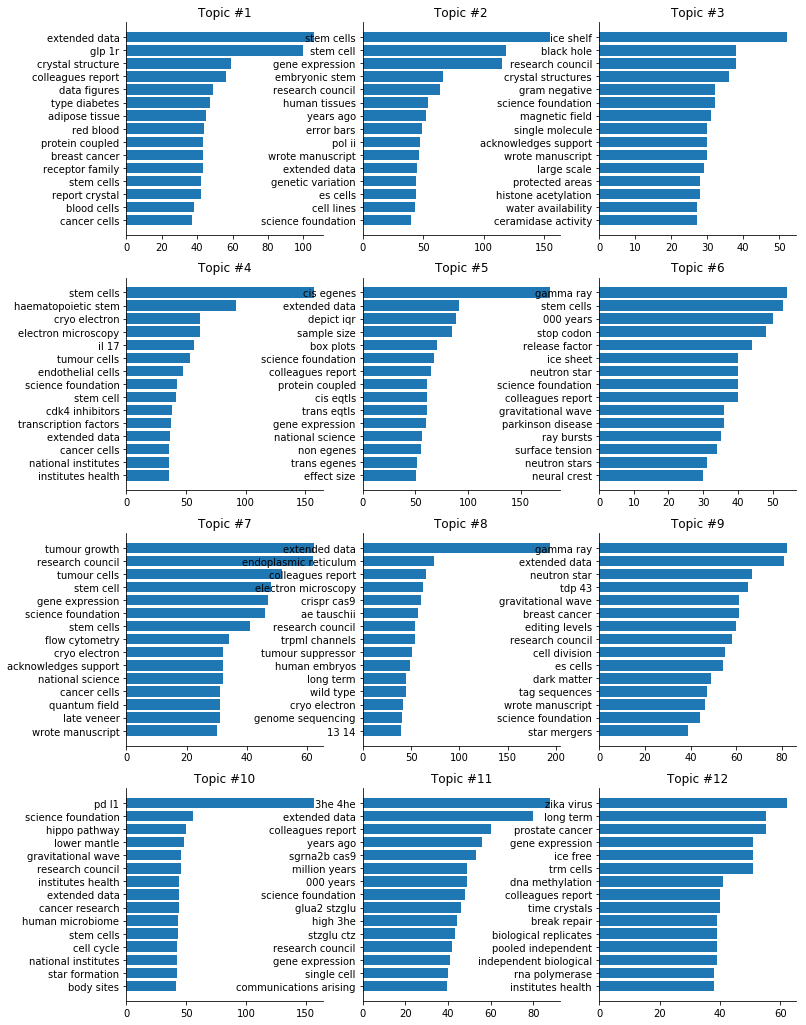

In [31]:
num_topics = 12
from sklearn.feature_extraction import stop_words

stopwords = list(stop_words.ENGLISH_STOP_WORDS)


black_list = ["file", "contains", "et", "al", "nature", 
 "letter", "supplementary", "news", "views", 
 "article", "letters", "articles", "table", 
 "tables", "figure", "work", "supported", 
 "author", "authors", "contributed", "fig", 
 "199", "200", "reference", "references"]

stopwords = set(stopwords + black_list)

vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(2,2))

#Fit and transform the count vectorizer
X_counts = vectorizer.fit_transform(df['text'])

lda = LatentDirichletAllocation(n_topics=num_topics, learning_method='batch')
lda.fit(X_counts)

components = lda.components_
feature_names = vectorizer.get_feature_names()

fig, axes = plt.subplots(4,3, figsize=(12, 18))
for component,ax,i in zip(components, axes.flatten(), range(1,num_topics + 1)):
    plot_features(component, feature_names, ax=ax, title = 'Topic #%d' %i)

### LDA and Visualization with Gensim

In [53]:
import PyPDF2
import csv

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from gensim import corpora
from gensim.models import LdaModel

import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans

import pyLDAvis.gensim

def bigram_preprocess(tokens, deacc=True, lowercase=True, errors='ignore',
    stemmer=None, stopwords=None):
    """
    Convert a document into a list of tokens.
    Split text into sentences and sentences into bigrams.
    the bigrams returned are the tokens
    """
    bigrams = []

    if len(tokens) >1:
        for i in range(0,len(tokens)-1):
            yield tokens[i] + '_' + tokens[i+1]

#nltk.download()

In [60]:
df = pd.read_csv('nature.txt', encoding='latin1')

documents = df['text']

black_list = ["file", "contains", "et", "al", "nature", 
 "letter", "supplementary", "news", "views", 
 "article", "letters", "articles", "table", 
 "tables", "figure", "work", "supported", 
 "author", "authors", "contributed", "fig", 
 "199", "200", "reference", "references"]


stop_words = set(list(stopwords.words('english')) + black_list)

texts = [word_tokenize(doc)  for doc in documents]
texts_lower = [[word.lower() for word in text] for text in texts]
unigrams = [[word for word in text if not word.isdigit() and word not in stop_words and len(word) > 1] for text in texts_lower]

bigrams = [[bigram for bigram in bigram_preprocess(text)] for text in unigrams]

dictionary_bigrams = corpora.Dictionary(bigrams, prune_at=20000000)
dictionary_bigrams.save_as_text('gensim_dict_bigrams.txt')

dictionary_unigrams = corpora.Dictionary(unigrams, prune_at=20000000)
dictionary_unigrams.save_as_text('gensim_dict_unigrams.txt')

In [61]:
corpus = [dictionary_bigrams.doc2bow(text) for text in bigrams]
lda = LdaModel(corpus, num_topics=10, id2word=dictionary)

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      11.796675        1       1 -0.010468 -0.020979
6      11.020621        1       2 -0.016586  0.003611
3      10.607055        1       3 -0.010674  0.010451
9      10.356511        1       4 -0.002129 -0.011361
5      10.091323        1       5  0.004581  0.010245
4       9.847999        1       6  0.025786  0.004549
2       9.628962        1       7  0.012641 -0.017009
0       9.604714        1       8  0.000879  0.007571
7       8.642756        1       9 -0.003206  0.007375
1       8.403385        1      10 -0.000824  0.005547, topic_info=       Category        Freq                    Term       Total  loglift  \
term                                                                       
118521  Default  452.000000              stem_cells  452.000000  30.0000   
85050   Default   86.000000  communications_arising   86.000000  29.0000   
241757  Default   86.000000    brief_communications   86.000000  28.0000   
155520  Default   44.000000           arising_brief   44.000000  27.0000   
68963   Default  610.000000           extended_data  610.000000  26.0000   
212424  Default   43.000000               trm_cells   43.000000  25.0000   
233414  Default  336.000000         colleagues_show  336.000000  24.0000   
187543  Default   15.000000          human_lifespan   15.000000  23.0000   
178082  Default  104.000000     haematopoietic_stem  104.000000  22.0000   
209015  Default   44.000000             ae_tauschii   44.000000  21.0000   
28257   Default   13.000000             limit_human   13.000000  20.0000   
187691  Default   13.000000           x._milholland   13.000000  19.0000   
247704  Default   13.000000           vijg_evidence   13.000000  18.0000   
135302  Default   13.000000         milholland_vijg   13.000000  17.0000   
20987   Default   13.000000                 dong_x.   13.000000  16.0000   
246167  Default   13.000000          evidence_limit   13.000000  15.0000   
100560  Default   21.000000            neural_crest   21.000000  14.0000   
75293   Default   13.000000        lifespan_257259   13.000000  13.0000   
5905    Default  207.000000               stem_cell  207.000000  12.0000   
42296   Default   41.000000               red_blood   41.000000  11.0000   
138259  Default   18.000000       hypothalamic_stem   18.000000  10.0000   
216987  Default   96.000000                es_cells   96.000000   9.0000   
209423  Default   29.000000               th17_cell   29.000000   8.0000   
10041   Default   38.000000               open_open   38.000000   7.0000   
129012  Default   86.000000        pluripotent_stem   86.000000   6.0000   
212008  Default   22.000000      expanded_potential   22.000000   5.0000   
248249  Default  345.000000         gene_expression  345.000000   4.0000   
69062   Default   42.000000          trpml_channels   42.000000   3.0000   
86346   Default   22.000000               high_salt   22.000000   2.0000   
113223  Default  113.000000         dna_methylation  113.000000   1.0000   
...         ...         ...                     ...         ...      ...   
118521  Topic10   32.946780              stem_cells  452.547387  -0.1435   
213487  Topic10   24.580810        national_science  272.614762   0.0704   
187181  Topic10   24.485390       institutes_health  283.271670   0.0282   
46451   Topic10   11.625265             amino_acids   76.984686   0.5861   
207948  Topic10   10.388645          adipose_tissue   63.384147   0.6680   
18146   Topic10   28.739073      science_foundation  403.694541  -0.1659   
19305   Topic10   22.974675     national_institutes  268.755085   0.0171   
36871   Topic10   22.441306                per_cent  261.695654   0.0203   
147167  Topic10   15.597406           howard_hughes  142.369574   0.2652   
247155  Topic10   24.387223       colleagues_report  342.669511  -0.1662   
22414   Topic10   17.452935            ca

In [62]:
corpus = [dictionary_unigrams.doc2bow(text) for text in unigrams]
lda = LdaModel(corpus, num_topics=10, id2word=dictionary)

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
9      15.299494        1       1  0.003014 -0.016859
7      14.165355        1       2 -0.017940 -0.004437
4      11.394304        1       3 -0.006559  0.004676
0      10.735075        1       4  0.005363 -0.001594
5      10.115356        1       5  0.002793 -0.002967
1       8.696606        1       6  0.011010  0.000013
8       8.507405        1       7 -0.000528  0.007886
2       7.987715        1       8  0.004829 -0.003697
6       7.237016        1       9  0.005389  0.012990
3       5.861674        1      10 -0.007371  0.003989, topic_info=       Category         Freq                        Term        Total  \
term                                                                    
186306  Default  1748.000000             generate_acetic  1748.000000   
104470  Default  4255.000000         mystery_chromosomes  4255.000000   
207035  Default  2465.000000           interactions_ions  2465.000000   
252086  Default  2575.000000            structure_samwer  2575.000000   
133445  Default  1471.000000              crystals_zhang  1471.000000   
239502  Default  3577.000000         address_fundamental  3577.000000   
201666  Default  1040.000000          exciting_endeavour  1040.000000   
239147  Default  1569.000000       becoming_increasingly  1569.000000   
18205   Default  1410.000000          previous_suggested  1410.000000   
84065   Default  1851.000000              copies_pulling  1851.000000   
203239  Default  1182.000000        resisted_deformation  1182.000000   
78343   Default   753.000000           r.f.s_simulations   753.000000   
129710  Default  1685.000000                 enter_leave  1685.000000   
1483    Default  2141.000000            cells_associated  2141.000000   
1037    Default  1301.000000              whose_magnetic  1301.000000   
42454   Default  1305.000000               analyses_mice  1305.000000   
243186  Default   367.000000             cent_anticipate   367.000000   
172476  Default  1642.000000                ions_induced  1642.000000   
102920  Default   978.000000                   savoia_a.   978.000000   
140918  Default   492.000000        genomes_brca1-linked   492.000000   
164661  Default   624.000000       salk-grant_government   624.000000   
54763   Default  1277.000000                muri_modular  1277.000000   
233816  Default  1458.000000                 cell_samwer  1458.000000   
67958   Default  1226.000000              track_persons  1226.000000   
44525   Default  1103.000000              exotic_quantum  1103.000000   
66525   Default  1192.000000       assemblages7_proposed  1192.000000   
26866   Default   950.000000            molecules_yellow   950.000000   
193642  Default  1196.000000           advances_exciting  1196.000000   
158032  Default   802.000000        press_correspondence   802.000000   
87889   Default  1338.000000           consortium_d.n.m.  1338.000000   
...         ...          ...                         ...          ...   
35818   Topic10    90.127449                 m.e.s_wrote  1216.165331   
96042   Topic10    80.475399                c.e.p._a.be.  1038.140802   
252086  Topic10   147.816897            structure_samwer  2575.509369   
186306  Topic10   111.983628             generate_acetic  1748.233919   
151713  Topic10    54.288663                 e.c.s_a.m.p   594.138219   
98209   Topic10    56.268053                 iarpa_logiq   628.011795   
1483    Topic10   125.208226            cells_associated  2141.808499   
172476  Topic10   102.766198                ions_induced  1642.317963   
52620   Topic10    57.250951  energies_teraelectronvolts   698.432893   
162192  Topic10    83.865504                curr_allergy  1278.448872   
158032  Topic10    61.491578        press_correspondence   802.844984   
17069   Topic10    90.502096                 affects_gut  1482.371377   
250424  Topic10    78.14